In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
def categorized_col(df,car_th=20,num_th=10):
  #this function categorizes features and enables to make operations with them.
  cat_col = []
  num_col = []
  car_col = []
  for col in df.columns:
    if df[col].dtype in ["object","category","boolean"]:
      if df[col].nunique() < car_th:
        cat_col.append(col)
      else:
        car_col.append(col) #cardinal features.
    else: #df[col].dtype in ["int","float"]:
      if df[col].nunique() < num_th:
        cat_col.append(col)
      else:
        num_col.append(col)

  print(f"rows: {df.shape[0]}")
  print(f"columns: {df.shape[1]}")
  print(f"categorical columns: {len(cat_col)}")
  print(f"numerical columns: {len(num_col)}")
  print(f"cardinal columns: {len(car_col)}\n")

  return cat_col,num_col,car_col

def info_col(df):
  #gives insights about categorized features.
  cat_col,num_col,car_col = categorized_col(df)

  for col in df:
    if col in cat_col:
      print(f"{col}'s info:\n {df[col].value_counts()}")
    elif col in num_col:
      print(f"{col}'s info:\n {df[col].describe()}")
    else:
      print(f"{col} is a cardinal column.\n")

In [55]:
def target_info(data,target):
  #this function shows relations between target feature and other features according to their categories.
  cat_col,num_col,car_col = categorized_col(data)
  cat_col.remove(target)

  for col in cat_col:
    print(pd.DataFrame(data.groupby(col)[target].mean()),end='\n')

  for col in num_col:
    print(pd.DataFrame(data.groupby(target)[col].mean()))

In [56]:
def outlier_thresholds(data,col,q1=0.25,q3=0.75):
  #calculates thresholds with iqr method and returns.
  q11 = data[col].quantile(q1)
  q33 = data[col].quantile(q3)


  iqr = q33-q11

  low = q11-1.5*iqr
  up = q33+iqr*1.5

  return low,up


def find_outliers(data,col,q1=0.25,q3=0.75):
  #this function uses iqr method to detect outliers.
  low,up = outlier_thresholds(data,col,q1,q3)

  if data[(data[col]<low)|(data[col]>up)].any(axis=None):
    return True
  else:
    return False

def replace_outliers(data,col,q1=0.25,q3=0.75):
  #replaces outliers with iqr thresholds.
  low,up = outlier_thresholds(data,col)
  data.loc[data[col]<low,col] = low
  data.loc[data[col]>up,col] = up



In [57]:
data = pd.read_csv("/content/diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [58]:
data['Outcome'].value_counts() #taking a look to how target variable distributes.

0    500
1    268
Name: Outcome, dtype: int64

In [59]:
info_col(data)

rows: 768
columns: 9
categorical columns: 1
numerical columns: 8
cardinal columns: 0

Pregnancies's info:
 count    768.000000
mean       3.845052
std        3.369578
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       17.000000
Name: Pregnancies, dtype: float64
Glucose's info:
 count    768.000000
mean     120.894531
std       31.972618
min        0.000000
25%       99.000000
50%      117.000000
75%      140.250000
max      199.000000
Name: Glucose, dtype: float64
BloodPressure's info:
 count    768.000000
mean      69.105469
std       19.355807
min        0.000000
25%       62.000000
50%       72.000000
75%       80.000000
max      122.000000
Name: BloodPressure, dtype: float64
SkinThickness's info:
 count    768.000000
mean      20.536458
std       15.952218
min        0.000000
25%        0.000000
50%       23.000000
75%       32.000000
max       99.000000
Name: SkinThickness, dtype: float64
Insulin's info:
 count    768.000000
mean      79.7994

In [60]:
data.isna().sum() #checking if there is any missing values.

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [61]:
zeros = [col for col in data.columns if data.loc[data[col]==0,col].count()!=0 ] #having zeros in some columns is strange so I'm checking them.
zeros

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'Outcome']

In [62]:
zeros.remove('Pregnancies')
zeros.remove('Outcome')
#I figured that other columns than pregnancies and outcome in zeros list has zeros as nan values.

In [63]:
for col in zeros:
  data.loc[data[col]==0,col] = np.nan #converting zeros to nan.

In [64]:
[col for col in data.columns if data.loc[data[col]==0,col].count()!=0] #ensuring that all zeros've been converted to nan.

['Pregnancies', 'Outcome']

In [65]:
data.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [66]:
#handling missing values.
for col in zeros:
  data[col].fillna(data[col].mean(),inplace=True)

data.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [67]:
#detecting columns with outliers.
outlier_col = []
for col in data.columns:
  print(col,find_outliers(data,col,q1=0.05,q3=0.95))
  if find_outliers(data,col,q1=0.05,q3=0.95):
    outlier_col.append(col)

outlier_col

Pregnancies False
Glucose False
BloodPressure False
SkinThickness True
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


['SkinThickness', 'Insulin']

In [68]:
#replacing outliers with thresholds.
for col in outlier_col:
  replace_outliers(data,col,q1=0.05,q3=0.95)

In [69]:
#controling the data to be sure that outliers've been replaced correctly.
for col in data.columns:
  print(col,find_outliers(data,col,q1=0.05,q3=0.95))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


In [70]:
#taking a look at relations between target feature and others.
target_info(data,'Outcome')

rows: 768
columns: 9
categorical columns: 1
numerical columns: 8
cardinal columns: 0

         Pregnancies
Outcome             
0           3.298000
1           4.865672
            Glucose
Outcome            
0        110.710121
1        142.165573
         BloodPressure
Outcome               
0            70.935397
1            75.147324
         SkinThickness
Outcome               
0            27.710651
1            31.152989
            Insulin
Outcome            
0        136.246832
1        158.285722
               BMI
Outcome           
0        30.888434
1        35.384757
         DiabetesPedigreeFunction
Outcome                          
0                        0.429734
1                        0.550500
               Age
Outcome           
0        31.190000
1        37.067164


In [71]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000000,1.00000,3.000000,6.000000,17.000000
Glucose,768.0,121.686763,30.435949,44.000000,99.75000,117.000000,140.250000,199.000000
BloodPressure,768.0,72.405184,12.096346,24.000000,64.00000,72.202592,80.000000,122.000000
SkinThickness,768.0,28.911883,7.443497,14.500000,25.00000,29.153420,32.000000,42.500000
Insulin,768.0,143.937487,39.496793,70.427665,121.50000,155.548223,155.548223,206.620558
BMI,768.0,32.457464,6.875151,18.200000,27.50000,32.400000,36.600000,67.100000
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078000,0.24375,0.372500,0.626250,2.420000
Age,768.0,33.240885,11.760232,21.000000,24.00000,29.000000,41.000000,81.000000
Outcome,768.0,0.348958,0.476951,0.000000,0.00000,0.000000,1.000000,1.000000


In [72]:
#feature engineering:
data['AGE_FLAG'] = pd.cut(data['Age'],[20,40,60,82],labels=['adult','middle-aged','old'])
data['BMI_FLAG'] = pd.cut(data['BMI'],[20,25,30,35,69],labels=['normal','over-weight','obese','extremely-obese'])
data['GLUCOSE_FLAG'] = pd.cut(data['Glucose'],[44,70,130,200],labels=['low','normal','high'])
data['BP_FLAG'] = pd.cut(data['BloodPressure'],[24,80,90,123],labels=['normal','high-normal','high'])
data.loc[data['Pregnancies']==0,'PREGNANT_FLAG'] = 'not-pregnant'
data.loc[data['Pregnancies']!=0,'PREGNANT_FLAG'] = 'pregnant'
data['G/I'] = data['Glucose']/data['Insulin']
data['G/BMI'] = data['Glucose']/data['BMI']

data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AGE_FLAG,BMI_FLAG,GLUCOSE_FLAG,BP_FLAG,PREGNANT_FLAG,G/I,G/BMI
0,6,148.0,72.0,35.00000,155.548223,33.6,0.627,50,1,middle-aged,obese,high,normal,pregnant,0.951473,4.404762
1,1,85.0,66.0,29.00000,155.548223,26.6,0.351,31,0,adult,over-weight,normal,normal,pregnant,0.546454,3.195489
2,8,183.0,64.0,29.15342,155.548223,23.3,0.672,32,1,adult,normal,high,normal,pregnant,1.176484,7.854077
3,1,89.0,66.0,23.00000,94.000000,28.1,0.167,21,0,adult,over-weight,normal,normal,pregnant,0.946809,3.167260
4,0,137.0,40.0,35.00000,168.000000,43.1,2.288,33,1,adult,extremely-obese,high,normal,not-pregnant,0.815476,3.178654


In [73]:
cat_col,num_col,car_col = categorized_col(data)

rows: 768
columns: 16
categorical columns: 6
numerical columns: 10
cardinal columns: 0



In [74]:
#scaling numeric columns to have a proper model.
from sklearn.preprocessing import MinMaxScaler

for col in num_col:
  data[col] = MinMaxScaler().fit_transform(data[[col]])

data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AGE_FLAG,BMI_FLAG,GLUCOSE_FLAG,BP_FLAG,PREGNANT_FLAG,G/I,G/BMI
0,0.352941,0.670968,0.489796,0.732143,0.625000,0.314928,0.234415,0.483333,1,middle-aged,obese,high,normal,pregnant,0.294157,0.431760
1,0.058824,0.264516,0.428571,0.517857,0.625000,0.171779,0.116567,0.166667,0,adult,over-weight,normal,normal,pregnant,0.115966,0.253304
2,0.470588,0.896774,0.408163,0.523336,0.625000,0.104294,0.253629,0.183333,1,adult,normal,high,normal,pregnant,0.393153,0.940787
3,0.058824,0.290323,0.428571,0.303571,0.173081,0.202454,0.038002,0.000000,0,adult,over-weight,normal,normal,pregnant,0.292105,0.249138
4,0.000000,0.600000,0.163265,0.732143,0.716428,0.509202,0.943638,0.200000,1,adult,extremely-obese,high,normal,not-pregnant,0.234324,0.250819


In [75]:
#encoding categoric columns.
cat_col.remove('Outcome')

data = pd.get_dummies(data,columns=cat_col,drop_first=True)

data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,G/I,...,AGE_FLAG_middle-aged,AGE_FLAG_old,BMI_FLAG_over-weight,BMI_FLAG_obese,BMI_FLAG_extremely-obese,GLUCOSE_FLAG_normal,GLUCOSE_FLAG_high,BP_FLAG_high-normal,BP_FLAG_high,PREGNANT_FLAG_pregnant
0,0.352941,0.670968,0.489796,0.732143,0.625000,0.314928,0.234415,0.483333,1,0.294157,...,1,0,0,1,0,0,1,0,0,1
1,0.058824,0.264516,0.428571,0.517857,0.625000,0.171779,0.116567,0.166667,0,0.115966,...,0,0,1,0,0,1,0,0,0,1
2,0.470588,0.896774,0.408163,0.523336,0.625000,0.104294,0.253629,0.183333,1,0.393153,...,0,0,0,0,0,0,1,0,0,1
3,0.058824,0.290323,0.428571,0.303571,0.173081,0.202454,0.038002,0.000000,0,0.292105,...,0,0,1,0,0,1,0,0,0,1
4,0.000000,0.600000,0.163265,0.732143,0.716428,0.509202,0.943638,0.200000,1,0.234324,...,0,0,0,0,1,0,1,0,0,0


In [76]:
#seperating target feature and other features.
x = data.drop('Outcome',axis=1)
y = data['Outcome']

In [77]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_validate, GridSearchCV, validation_curve

In [87]:
#building base models and evaluating them.
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
gbm = GradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
lgbm = LGBMClassifier(random_state=42)

dt_cv = cross_validate(dt,x,y,scoring=['accuracy','f1','roc_auc'],cv=5,n_jobs=-1)
rf_cv = cross_validate(rf,x,y,scoring=['accuracy','f1','roc_auc'],cv=5,n_jobs=-1)
gbm_cv = cross_validate(gbm,x,y,scoring=['accuracy','f1','roc_auc'],cv=5,n_jobs=-1)
xgb_cv = cross_validate(xgb,x,y,scoring=['accuracy','f1','roc_auc'],cv=5,n_jobs=-1)
lgbm_cv = cross_validate(lgbm,x,y,scoring=['accuracy','f1','roc_auc'],cv=5,n_jobs=-1)

print(f"***DT***\n accuracy:{dt_cv['test_accuracy'].mean()}\tf1:{dt_cv['test_f1'].mean()}\troc_auc:{dt_cv['test_roc_auc'].mean()}")
print(f"***RF***\n accuracy:{rf_cv['test_accuracy'].mean()}\tf1:{rf_cv['test_f1'].mean()}\troc_auc:{rf_cv['test_roc_auc'].mean()}")
print(f"***GBM***\n accuracy:{gbm_cv['test_accuracy'].mean()}\tf1:{gbm_cv['test_f1'].mean()}\troc_auc:{gbm_cv['test_roc_auc'].mean()}")
print(f"***XGB***\n accuracy:{xgb_cv['test_accuracy'].mean()}\tf1:{xgb_cv['test_f1'].mean()}\troc_auc:{xgb_cv['test_roc_auc'].mean()}")
print(f"***LGBM***\n accuracy:{lgbm_cv['test_accuracy'].mean()}\tf1:{lgbm_cv['test_f1'].mean()}\troc_auc:{lgbm_cv['test_roc_auc'].mean()}")
#picking models with highest success(according to accuracy and roc_auc score). -> chosen models: rf,gbm

***DT***
 accuracy:0.6810627281215517	f1:0.5575594510151655	roc_auc:0.6563864430468205
***RF***
 accuracy:0.7643748408454292	f1:0.6369546528587697	roc_auc:0.82848392732355
***GBM***
 accuracy:0.7578728461081403	f1:0.6397308001070378	roc_auc:0.8313102725366877
***XGB***
 accuracy:0.7357100415923945	f1:0.6139399329525861	roc_auc:0.8049496855345912
***LGBM***
 accuracy:0.747440794499618	f1:0.6314989308132717	roc_auc:0.8149189378057302


In [88]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [89]:
gbm.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [90]:
#hyperparameter optimization:
rf_params = {'max_depth':[3,5,8],'min_samples_split':[2,4,6,],'n_estimators':[100,200]}
gbm_params = {'max_depth':[3,5,8],'min_samples_split':[2,4,6,],'n_estimators':[100,200],'learning_rate':[0.1,0.05]}

In [91]:
rf_grid_cv = GridSearchCV(rf,rf_params,cv=5,n_jobs=-1).fit(x,y)
gbm_grid_cv = GridSearchCV(gbm,gbm_params,cv=5,n_jobs=-1).fit(x,y)

#setting best parameters to base model and building final model.

rf_final = rf.set_params(**rf_grid_cv.best_params_).fit(x,y)
gbm_final = gbm.set_params(**gbm_grid_cv.best_params_).fit(x,y)

In [92]:
#evaluating final models.
rf_cv = cross_validate(rf_final,x,y,scoring=['accuracy','f1','roc_auc'],cv=5,n_jobs=-1)
gbm_cv = cross_validate(gbm_final,x,y,scoring=['accuracy','f1','roc_auc'],cv=5,n_jobs=-1)


print(f"***RF FINAL***\n accuracy:{rf_cv['test_accuracy'].mean()}\tf1:{rf_cv['test_f1'].mean()}\troc_auc:{rf_cv['test_roc_auc'].mean()}")
print(f"***GBM FINAL***\n accuracy:{gbm_cv['test_accuracy'].mean()}\tf1:{gbm_cv['test_f1'].mean()}\troc_auc:{gbm_cv['test_roc_auc'].mean()}")

***RF FINAL***
 accuracy:0.7682624564977506	f1:0.6424162772551442	roc_auc:0.8410048916841368
***GBM FINAL***
 accuracy:0.7682794329853154	f1:0.6437249729887298	roc_auc:0.8256666666666668


In [93]:
def feature_imp(model,data):
  #this function visualizes the given model's feature importance.
  importance = pd.DataFrame({'Value':model.feature_importances_,'Feature':data.columns})

  plt.figure(figsize=(5,5))
  sns.barplot(x='Value',y='Feature',data=importance.sort_values(by='Value',ascending=False))
  plt.show()

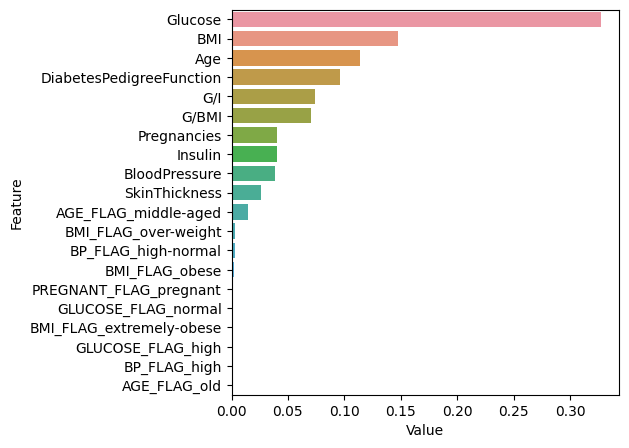

In [94]:
feature_imp(gbm_final,x)

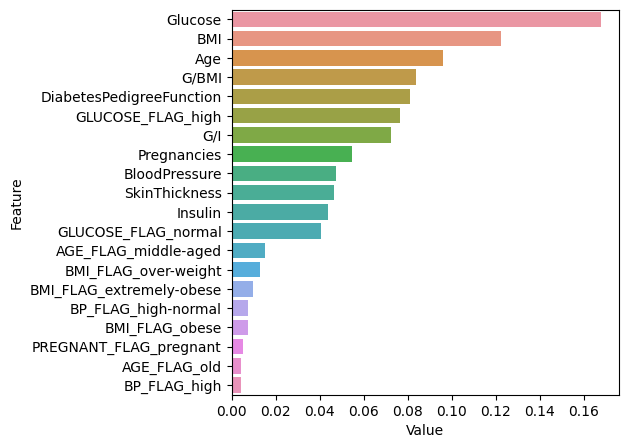

In [96]:
feature_imp(rf_final,x)